In [1]:
# Imports
import os
import tensorflow as tf
from tensorflow.keras import callbacks, preprocessing, optimizers, utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

####
import cv2 as cv
from tqdm import tqdm
from tifffile import imwrite, imread
####

import sys
sys.path.append('code')
import UNet
import CTUNet
from Loss_Metrics import jaccard_coef, jaccard_coef_loss, dice_coef_loss, binary_cross_iou
sys.path.append('../')

In [2]:
train_set = 'rgbLiDAR'
input_shape = (512, 512, 4)
weight = None
mask = 'mask'

In [3]:
model = UNet.EfficientNetB4_unet(input_shape, weight)
model.summary()
model.compile(optimizer=optimizers.Adam(learning_rate=0.000015), loss=[dice_coef_loss], metrics=[jaccard_coef, 'accuracy'])

Model: "EfficientNetB4_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 4  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 512, 512, 4)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 512, 512, 4)  9           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 513, 513, 4)  0           ['normalizatio

                                                                                                  
 block2a_expand_bn (BatchNormal  (None, 256, 256, 14  576        ['block2a_expand_conv[0][0]']    
 ization)                       4)                                                                
                                                                                                  
 block2a_expand_activation (Act  (None, 256, 256, 14  0          ['block2a_expand_bn[0][0]']      
 ivation)                       4)                                                                
                                                                                                  
 block2a_dwconv_pad (ZeroPaddin  (None, 257, 257, 14  0          ['block2a_expand_activation[0][0]
 g2D)                           4)                               ']                               
                                                                                                  
 block2a_d

 ization)                       2)                                                                
                                                                                                  
 block2c_expand_activation (Act  (None, 128, 128, 19  0          ['block2c_expand_bn[0][0]']      
 ivation)                       2)                                                                
                                                                                                  
 block2c_dwconv (DepthwiseConv2  (None, 128, 128, 19  1728       ['block2c_expand_activation[0][0]
 D)                             2)                               ']                               
                                                                                                  
 block2c_bn (BatchNormalization  (None, 128, 128, 19  768        ['block2c_dwconv[0][0]']         
 )                              2)                                                                
          

 block3a_expand_bn (BatchNormal  (None, 128, 128, 19  768        ['block3a_expand_conv[0][0]']    
 ization)                       2)                                                                
                                                                                                  
 block3a_expand_activation (Act  (None, 128, 128, 19  0          ['block3a_expand_bn[0][0]']      
 ivation)                       2)                                                                
                                                                                                  
 block3a_dwconv_pad (ZeroPaddin  (None, 131, 131, 19  0          ['block3a_expand_activation[0][0]
 g2D)                           2)                               ']                               
                                                                                                  
 block3a_dwconv (DepthwiseConv2  (None, 64, 64, 192)  4800       ['block3a_dwconv_pad[0][0]']     
 D)       

 D)                                                              ']                               
                                                                                                  
 block3c_bn (BatchNormalization  (None, 64, 64, 336)  1344       ['block3c_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3c_activation (Activation  (None, 64, 64, 336)  0          ['block3c_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block3c_se_squeeze (GlobalAver  (None, 336)         0           ['block3c_activation[0][0]']     
 agePooling2D)                                                                                    
          

 block4a_bn (BatchNormalization  (None, 32, 32, 336)  1344       ['block4a_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4a_activation (Activation  (None, 32, 32, 336)  0          ['block4a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4a_se_squeeze (GlobalAver  (None, 336)         0           ['block4a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4a_se_reshape (Reshape)   (None, 1, 1, 336)    0           ['block4a_se_squeeze[0][0]']     
          

                                                                                                  
 block4c_se_reduce (Conv2D)     (None, 1, 1, 28)     18844       ['block4c_se_reshape[0][0]']     
                                                                                                  
 block4c_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block4c_se_reduce[0][0]']      
                                                                                                  
 block4c_se_excite (Multiply)   (None, 32, 32, 672)  0           ['block4c_activation[0][0]',     
                                                                  'block4c_se_expand[0][0]']      
                                                                                                  
 block4c_project_conv (Conv2D)  (None, 32, 32, 112)  75264       ['block4c_se_excite[0][0]']      
                                                                                                  
 block4c_p

 block4e_se_excite (Multiply)   (None, 32, 32, 672)  0           ['block4e_activation[0][0]',     
                                                                  'block4e_se_expand[0][0]']      
                                                                                                  
 block4e_project_conv (Conv2D)  (None, 32, 32, 112)  75264       ['block4e_se_excite[0][0]']      
                                                                                                  
 block4e_project_bn (BatchNorma  (None, 32, 32, 112)  448        ['block4e_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4e_drop (Dropout)         (None, 32, 32, 112)  0           ['block4e_project_bn[0][0]']     
                                                                                                  
 block4e_a

 block5a_project_bn (BatchNorma  (None, 32, 32, 160)  640        ['block5a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5b_expand_conv (Conv2D)   (None, 32, 32, 960)  153600      ['block5a_project_bn[0][0]']     
                                                                                                  
 block5b_expand_bn (BatchNormal  (None, 32, 32, 960)  3840       ['block5b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5b_expand_activation (Act  (None, 32, 32, 960)  0          ['block5b_expand_bn[0][0]']      
 ivation)                                                                                         
          

 block5d_expand_bn (BatchNormal  (None, 32, 32, 960)  3840       ['block5d_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5d_expand_activation (Act  (None, 32, 32, 960)  0          ['block5d_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5d_dwconv (DepthwiseConv2  (None, 32, 32, 960)  24000      ['block5d_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block5d_bn (BatchNormalization  (None, 32, 32, 960)  3840       ['block5d_dwconv[0][0]']         
 )        

                                                                                                  
 block5f_dwconv (DepthwiseConv2  (None, 32, 32, 960)  24000      ['block5f_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block5f_bn (BatchNormalization  (None, 32, 32, 960)  3840       ['block5f_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block5f_activation (Activation  (None, 32, 32, 960)  0          ['block5f_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5f_s

 activation_3 (Activation)      (None, 128, 128, 25  0           ['batch_normalization_3[0][0]']  
                                6)                                                                
                                                                                                  
 conv2d_transpose_2 (Conv2DTran  (None, 256, 256, 12  131200     ['activation_3[0][0]']           
 spose)                         8)                                                                
                                                                                                  
 concatenate_2 (Concatenate)    (None, 256, 256, 27  0           ['conv2d_transpose_2[0][0]',     
                                2)                                'block2a_expand_activation[0][0]
                                                                 ']                               
                                                                                                  
 conv2d_4 

In [11]:
IMG_HEIGHT = 512
IMG_WIDTH = 512

seed = 24
batch_size = 6

img_data_gen_args = dict(rotation_range=90,
                      width_shift_range=0.3,
                      height_shift_range=0.3,
                      shear_range=0.5,
                      zoom_range=0.3,
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')

mask_data_gen_args = dict(rotation_range=90,
                      width_shift_range=0.3,
                      height_shift_range=0.3,
                      shear_range=0.5,
                      zoom_range=0.3,
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect',
                      preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) #Binarize the output again.


image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_generator = image_data_generator.flow_from_directory(os.path.normpath('dataset/MapAI/512x512_train/' + train_set),
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           seed=seed,
                                                           batch_size=batch_size,
                                                           color_mode='rgba',
                                                           class_mode=None)

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_generator = mask_data_generator.flow_from_directory(os.path.normpath('dataset/MapAI/512x512_train/' + mask),
                                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                         seed=seed,
                                                         batch_size=batch_size,
                                                         color_mode = 'grayscale',   #Read masks in grayscale
                                                         class_mode=None)

val_data_generator = ImageDataGenerator()
valid_img_generator = val_data_generator.flow_from_directory(os.path.normpath('dataset/MapAI/512x512_validation/' + train_set),
                                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                               seed=seed,
                                                               batch_size=batch_size,
                                                               color_mode='rgba',
                                                               class_mode=None)

valid_mask_generator = val_data_generator.flow_from_directory(os.path.normpath('dataset/MapAI/512x512_validation/' + mask),
                                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                               seed=seed,
                                                               batch_size=batch_size,
                                                               color_mode = 'grayscale',   #Read masks in grayscale
                                                               class_mode=None)

train_generator = zip(image_generator, mask_generator)
val_generator = zip(valid_img_generator, valid_mask_generator)

num_train_imgs = len(os.listdir(os.path.normpath('dataset/MapAI/512x512_train/' + train_set + '/train')))
num_val_imgs = len(os.listdir(os.path.normpath('dataset/MapAI/512x512_validation/' + train_set + '/val')))
train_steps_per_epoch = num_train_imgs // batch_size
val_steps_per_epoch = num_val_imgs // batch_size

Found 7000 images belonging to 1 classes.
Found 7000 images belonging to 1 classes.
Found 1500 images belonging to 1 classes.
Found 1500 images belonging to 1 classes.


In [5]:
# Create callback for model.
# ModelCheckpoint -> Creates checkpoints after each epoch
# EarlyStopping -> Stops the training of the model if it doesnt improve after some epochs
callback_list = [
    callbacks.ModelCheckpoint(os.path.normpath('../models/MapAI_UNet_Task1_Checkpoint.h5'), verbose=1, save_best_only=True),
    callbacks.EarlyStopping(monitor='val_loss', patience=6),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, verbose=1)
]

# Train the model
results = model.fit(train_generator, steps_per_epoch=train_steps_per_epoch, epochs=100, callbacks=callback_list, validation_data=val_generator, validation_steps=val_steps_per_epoch)


Epoch 1/100


InvalidArgumentError: Graph execution error:

Detected at node 'EfficientNetB4_U-Net/normalization/sub' defined at (most recent call last):
    File "C:\Users\erikf\anaconda3\envs\master\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\erikf\anaconda3\envs\master\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\erikf\anaconda3\envs\master\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\erikf\anaconda3\envs\master\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\erikf\anaconda3\envs\master\lib\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "C:\Users\erikf\anaconda3\envs\master\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\erikf\anaconda3\envs\master\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "C:\Users\erikf\anaconda3\envs\master\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "C:\Users\erikf\anaconda3\envs\master\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\erikf\anaconda3\envs\master\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\erikf\anaconda3\envs\master\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\erikf\anaconda3\envs\master\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\erikf\anaconda3\envs\master\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\erikf\anaconda3\envs\master\lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "C:\Users\erikf\anaconda3\envs\master\lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\erikf\anaconda3\envs\master\lib\site-packages\IPython\core\interactiveshell.py", line 2945, in run_cell
      result = self._run_cell(
    File "C:\Users\erikf\anaconda3\envs\master\lib\site-packages\IPython\core\interactiveshell.py", line 3000, in _run_cell
      return runner(coro)
    File "C:\Users\erikf\anaconda3\envs\master\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\erikf\anaconda3\envs\master\lib\site-packages\IPython\core\interactiveshell.py", line 3203, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\erikf\anaconda3\envs\master\lib\site-packages\IPython\core\interactiveshell.py", line 3382, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\erikf\anaconda3\envs\master\lib\site-packages\IPython\core\interactiveshell.py", line 3442, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\erikf\AppData\Local\Temp\ipykernel_5288\2707229425.py", line 11, in <module>
      results = model.fit(train_generator, steps_per_epoch=train_steps_per_epoch, epochs=100, callbacks=callback_list, validation_data=val_generator, validation_steps=val_steps_per_epoch)
    File "C:\Users\erikf\anaconda3\envs\master\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\erikf\anaconda3\envs\master\lib\site-packages\keras\engine\training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\erikf\anaconda3\envs\master\lib\site-packages\keras\engine\training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "C:\Users\erikf\anaconda3\envs\master\lib\site-packages\keras\engine\training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\erikf\anaconda3\envs\master\lib\site-packages\keras\engine\training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "C:\Users\erikf\anaconda3\envs\master\lib\site-packages\keras\engine\training.py", line 1023, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\erikf\anaconda3\envs\master\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\erikf\anaconda3\envs\master\lib\site-packages\keras\engine\training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\erikf\anaconda3\envs\master\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\erikf\anaconda3\envs\master\lib\site-packages\keras\engine\base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\erikf\anaconda3\envs\master\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\erikf\anaconda3\envs\master\lib\site-packages\keras\engine\functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\erikf\anaconda3\envs\master\lib\site-packages\keras\engine\functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\erikf\anaconda3\envs\master\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\erikf\anaconda3\envs\master\lib\site-packages\keras\engine\base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\erikf\anaconda3\envs\master\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\erikf\anaconda3\envs\master\lib\site-packages\keras\layers\preprocessing\normalization.py", line 361, in call
      return (inputs - self.mean) / tf.maximum(
Node: 'EfficientNetB4_U-Net/normalization/sub'
Incompatible shapes: [6,512,512,3] vs. [1,1,1,4]
	 [[{{node EfficientNetB4_U-Net/normalization/sub}}]] [Op:__inference_train_function_49614]

In [14]:
import matplotlib.pyplot as plt

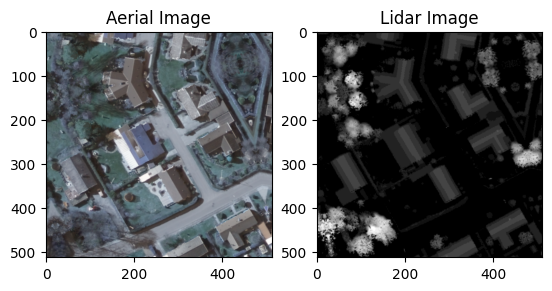

In [27]:
gen = image_generator.next()
for i in range(0,1):
    image = gen[i]
    # Find and display aerial image
    plt.subplot(121)
    plt.title('Aerial Image')
    plt.imshow(image[:, :, 0:3].astype(np.uint8))
    
    # Find and display mask image
    plt.subplot(122)
    plt.title('Lidar Image')
    plt.imshow(image[:, :, 3], cmap='gray')
    plt.show()